In [1]:
import parser
import json
import urllib
import pandas as pd
import imp
import numpy as np
import seaborn as sns
from tqdm import tqdm
import math

from sklearn.impute import SimpleImputer
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from PIL import Image
import matplotlib.pyplot as plt
import imdb_movie_content
from collections import Counter
%matplotlib inline
imp.reload(parser)
imp.reload(imdb_movie_content)

C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\64185873.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'imdb_movie_content' from 'C:\\Users\\duygu\\Downloads\\final_project\\notebooks\\imdb_movie_content.py'>

In [2]:
df = parser.create_dataframe(r'C:\Users\duygu\Downloads\final_project\data\raw\movie_contents.json',r'C:\Users\duygu\Downloads\final_project\data\raw\movie_budget.json')
df.set_index('movie_title', inplace=True, drop=False)
df.sort_index(inplace=True)
awards_columns = [col for col in df.columns if 'nominated' in col or 'won' in col]
df_awards = df[awards_columns]
awards_per_movie = (len(awards_columns) - df_awards.isnull().sum(axis=1)).to_dict()
df['nb_awards'] = df['movie_title'].map(awards_per_movie)
df = df.drop_duplicates(['movie_title'])
df = df.rename(columns = {'director_fb_links': 'director_fb_likes'})

# Awards and Gross

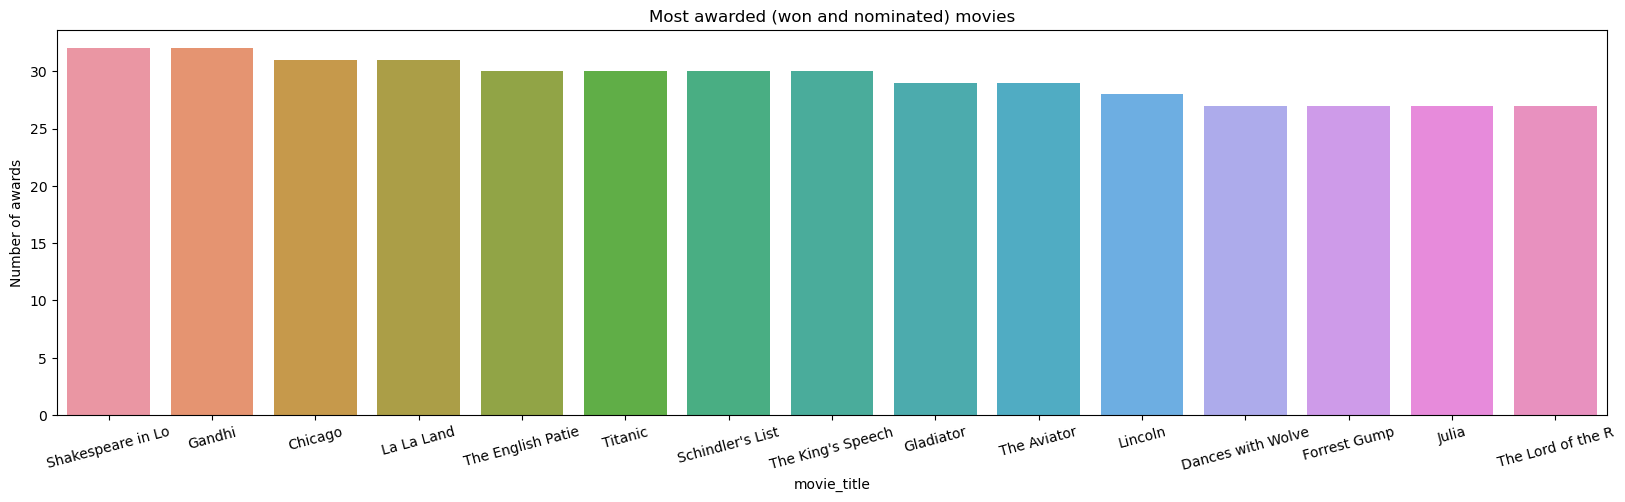

In [3]:
d = df['nb_awards'].sort_values(ascending=False)[:15]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Most awarded (won and nominated) movies')
_ = plot.set_ylabel('Number of awards')

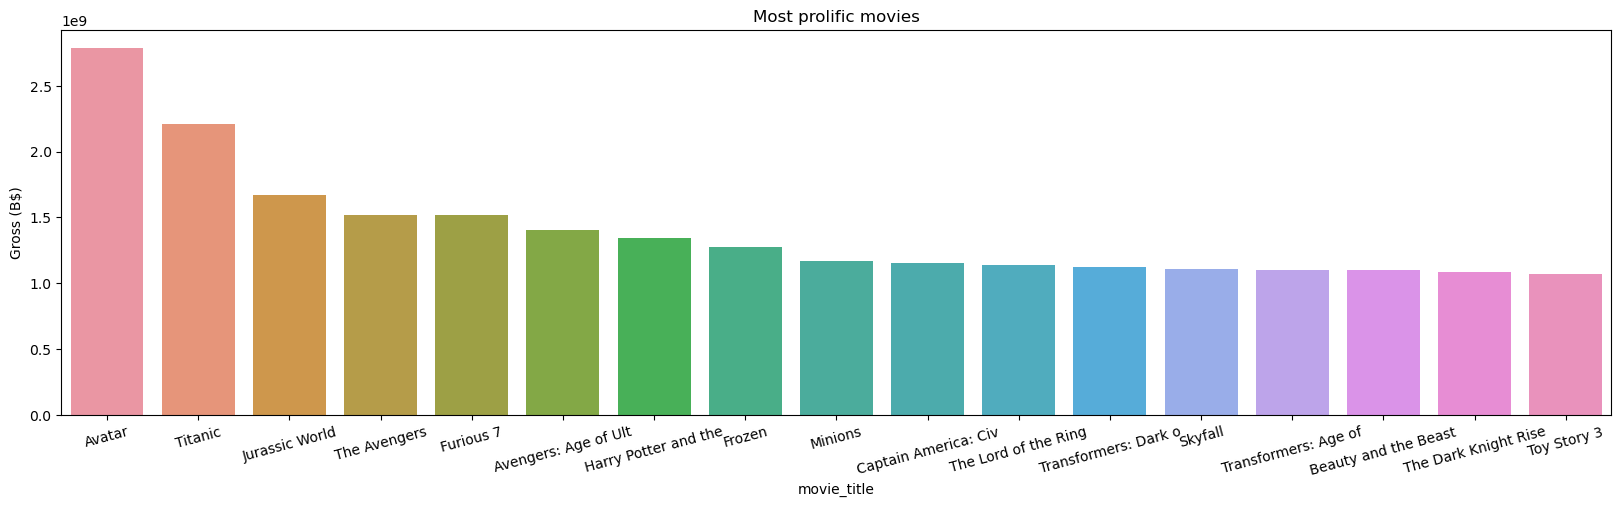

In [4]:
d = df.worldwide_gross.sort_values(ascending=False)[:17]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:20] for elem in d.index], rotation=15)
_ = plot.set_title('Most prolific movies')
_ = plot.set_ylabel('Gross (B$)')

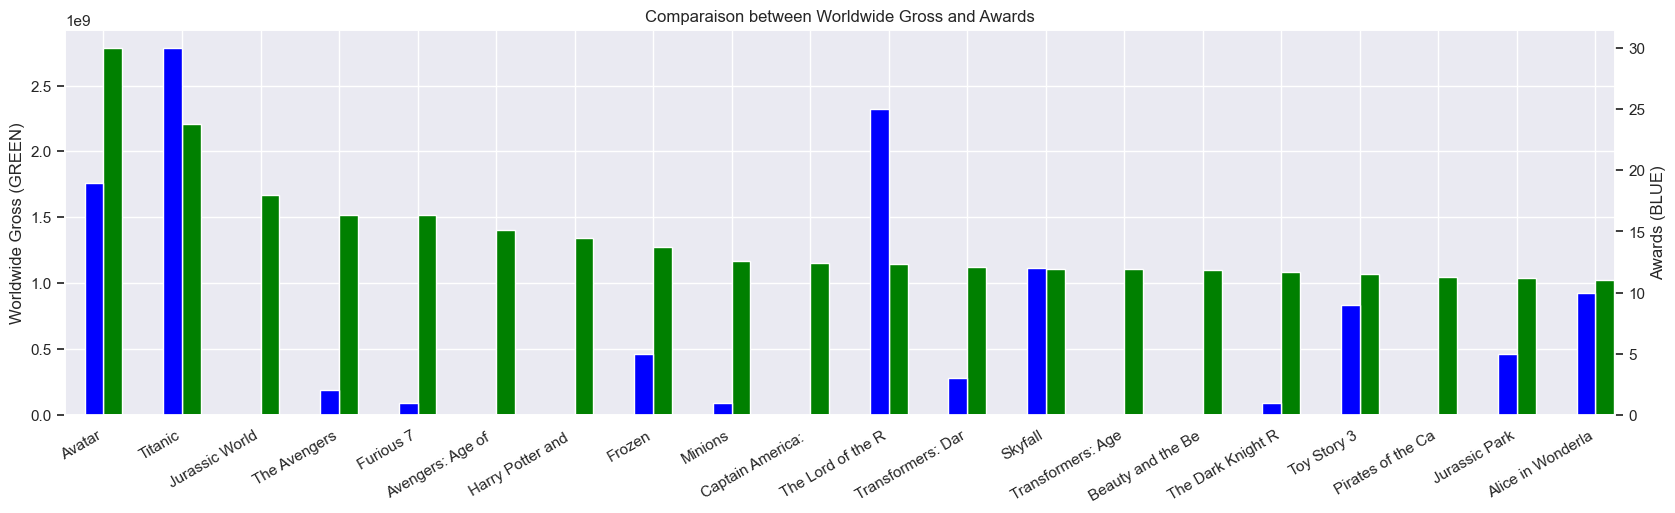

In [5]:
sns.set()

d = df.worldwide_gross.sort_values(ascending=False)[:20]
e = df_awards[df_awards.index.isin(d.index)].isnull().sum(axis=1)
e = len(awards_columns) - e[~e.index.duplicated(keep='first')].reindex(d.index)

margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Worldwide Gross (GREEN)')
ax2.set_ylabel('Awards (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Worldwide Gross and Awards')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

# Facebook likes

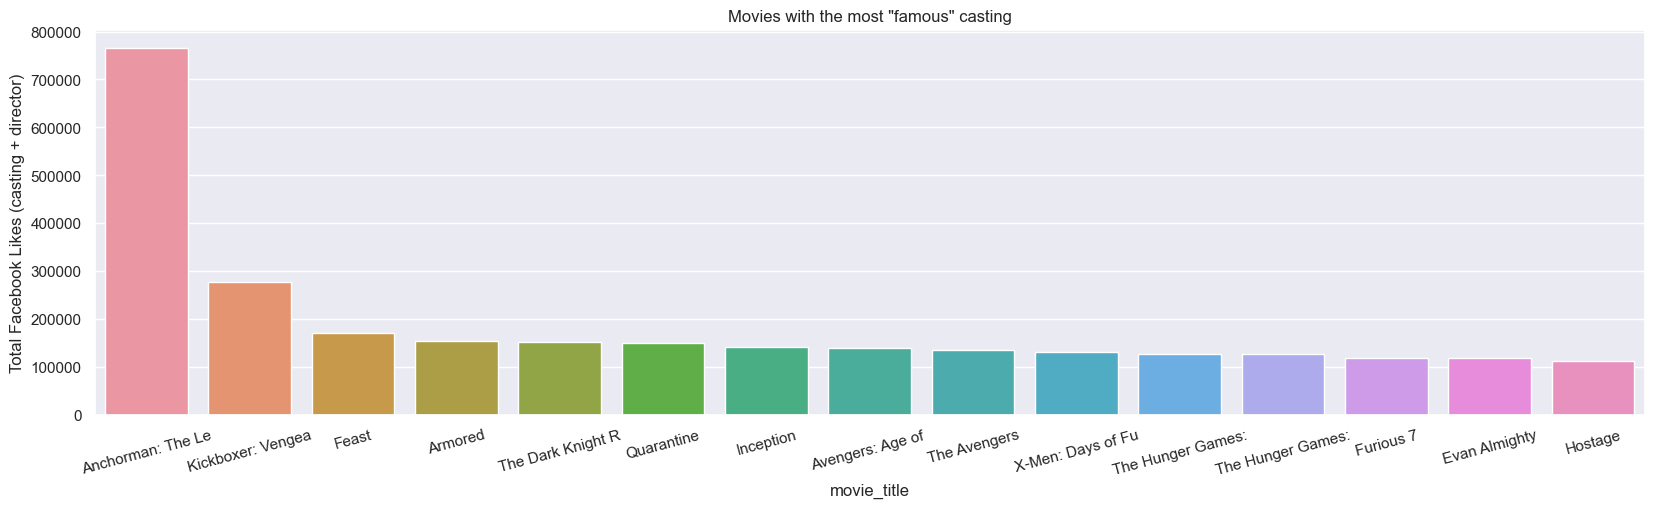

In [6]:
d = df['total_cast_fb_likes'].sort_values(ascending=False)[:15]
e = df[df.index.isin(d.index)].num_facebook_like
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Movies with the most "famous" casting')
_ = plot.set_ylabel('Total Facebook Likes (casting + director)')

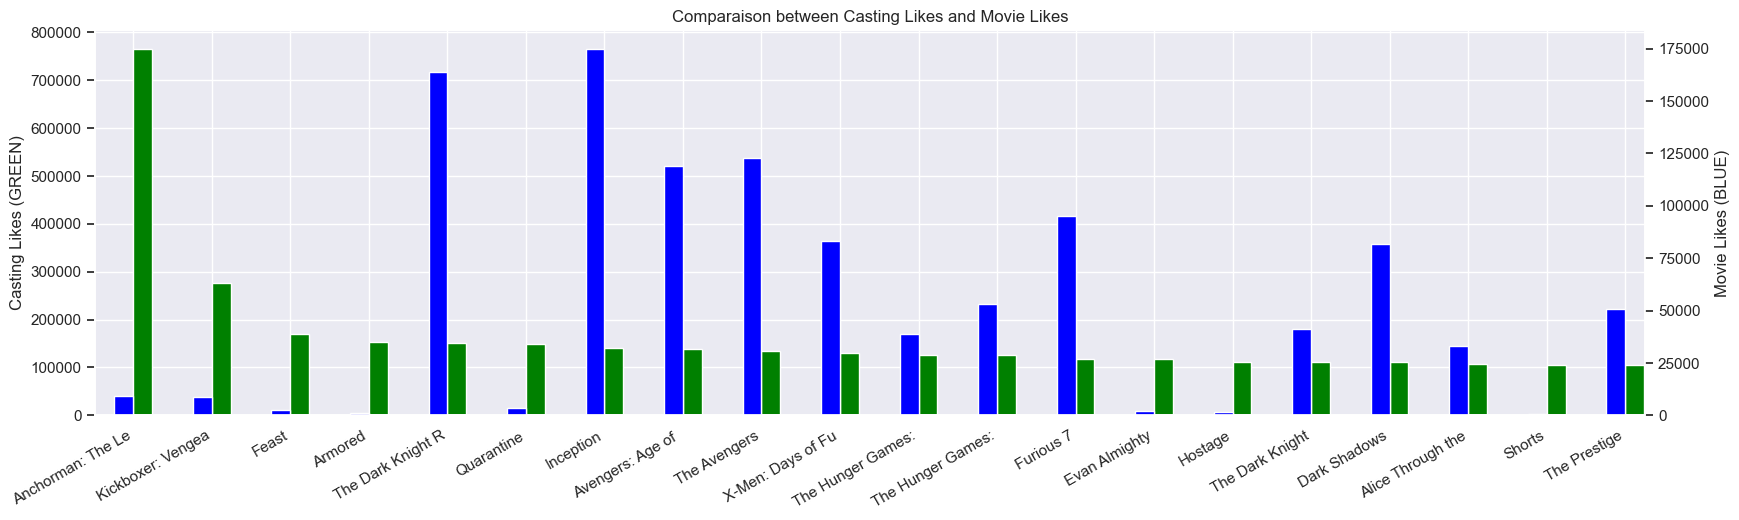

In [7]:
sns.set()

d = df['total_cast_fb_likes'].sort_values(ascending=False)[:20]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Casting Likes (GREEN)')
ax2.set_ylabel('Movie Likes (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Casting Likes and Movie Likes')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

# Best Actors

### Actor in movie

In [8]:
all_actors = [actor for actor in list(set(list(df.actor_1_name) + list(df.actor_2_name) + list(df.actor_3_name))) if pd.notnull(actor)]
imdb_score_per_actor = {}
for actor in all_actors:
    imdb_score_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].idmb_score.mean()

In [9]:
millnames = ['',' K',' M',' B']
def millify(n):
    if pd.notnull(n):
        n = float(n)
        millidx = max(0,min(len(millnames)-1,
                            int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
        return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
    else:
        return n

In [10]:
empty_actors = []
for actor in all_actors:
    temp = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)]["worldwide_gross"].values
    if np.isnan(temp).all():
        empty_actors.append(actor)

df = df[~(df.actor_1_name.isin(empty_actors)) | ~(df.actor_2_name.isin(empty_actors)) | ~(df.actor_3_name.isin(empty_actors))]

In [11]:
gross_per_actor = {}
all_actors = [actor for actor in all_actors if actor not in empty_actors ]
for actor in all_actors:
    gross_per_actor[actor] = np.nanmean(df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)]["worldwide_gross"].values).round(2)

In [12]:
from collections import Counter
from millify import millify

# Assuming you have loaded the data and defined 'df', 'gross_per_actor', and 'imdb_score_per_actor'

# Function to count the number of movies per actor
def count_movies(actor_name):
    return len(df[(df.actor_1_name == actor_name) | (df.actor_2_name == actor_name) | (df.actor_3_name == actor_name)])

# Filter actors with at least 'mini_movie' movies and sort by gross earnings
mini_movie = 3
top_k = 3
def get_best_mini_gross(gross_per_actor: dict, mini_movie: int=3) -> list:
    best_mini_gross = sorted(
        [(actor, earnings) for actor, earnings in gross_per_actor.items() if count_movies(actor) >= mini_movie],
        key=lambda x: x[1],
        reverse=True
    )[:20]
    return best_mini_gross

best_mini_gross = get_best_mini_gross(gross_per_actor)

 #Generate a formatted string for top actors by gross earnings
best_mini_gross_str = [
    f"{actor}, {millify(earnings)} ({count_movies(actor)} movie{'s' if count_movies(actor) > 1 else ''})"
    for actor, earnings in best_mini_gross[:top_k]
]

# Filter actors with at least 'mini_movie' movies and sort by IMDb score
best_mini = sorted(
    [(actor, score) for actor, score in imdb_score_per_actor.items() if count_movies(actor) >= mini_movie],
    key=lambda x: x[1],
    reverse=True
)[:20]

# Generate a formatted string for top actors by IMDb score
best_mini_str = [
    f"{actor}, {round(score, 2)} ({count_movies(actor)} movie{'s' if count_movies(actor) > 1 else ''})"
    for actor, score in best_mini[:top_k]
]




In [13]:
print('The {} best actors are (with minimum {} movies) : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_mini_str)))

print('\nThe {} most prolific actors are (with minimum {} movies) : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_mini_gross_str)))

The 3 best actors are (with minimum 3 movies) : 
Mark Hamill, 8.63 (3 movies)
Richard Attenborough, 8.03 (3 movies)
Gene Wilder, 7.87 (3 movies)

The 3 most prolific actors are (with minimum 3 movies) : 
Sam Worthington, 1B (3 movies)
Daniel Radcliffe, 877M (4 movies)
Richard Armitage, 826M (4 movies)


### First star in movie

In [14]:
import pandas as pd
from math import isnan

# Assuming you have already imported the 'millify' function.

# Assuming you have a DataFrame named 'df' with columns 'actor_1_name', 'idmb_score', 'worldwide_gross', and 'movie_title'.

big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['idmb_score', 'worldwide_gross'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())

# Check and replace NaN values in 'nb_movies' column with 0.
big_star['nb_movies'] = big_star['nb_movies'].apply(lambda x: 0 if isnan(x) else x)

# Assuming 'millify' is a function to convert numbers to a more readable format (e.g., 1000000 -> '1M'), you can apply it to 'worldwide_gross' here.

top_k = 7
print('The {} best actors as the most famous actor are:'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)


The 7 best actors as the most famous actor are:


C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\812436325.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['idmb_score', 'worldwide_gross'], ascending=False)


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Gene Wilder,7.866667,6.993333e+07,3
Richard Armitage,7.733333,9.774967e+08,3
Benedict Cumberbatch,7.700000,3.475776e+08,3
Matthew McConaughey,7.675000,2.134377e+08,4
Leonardo DiCaprio,7.661538,3.003672e+08,13
Tom Hanks,7.483333,3.184800e+08,12
Tom Hardy,7.483333,2.779333e+08,6


In [15]:
# Import millify function if not already done
from millify import millify

big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['worldwide_gross', 'idmb_score'], ascending=False)

# Replace NaN values in 'worldwide_gross' column with 0
big_star['worldwide_gross'].fillna(0, inplace=True)

# Apply millify function to 'worldwide_gross' column
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)

big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())

# Replace NaN values in 'nb_movies' column with 0
big_star['nb_movies'].fillna(0, inplace=True)

top_k = 7
print('The {} most prolific actors as the most famous actor are:'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 most prolific actors as the most famous actor are:


C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\1574134515.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['worldwide_gross', 'idmb_score'], ascending=False)


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Richard Armitage,7.733333,977M,3
Sean Bean,7.033333,599M,3
Chris Hemsworth,6.950000,585M,8
Sacha Baron Cohen,6.966667,578M,3
Christopher Lee,6.640000,558M,5
Jennifer Lawrence,7.118182,489M,11
Robert Pattinson,5.866667,482M,6


# IMDB rating and other variables

Text(0.5, 1.0, 'Gross and Movie Likes compared to IMDB score')

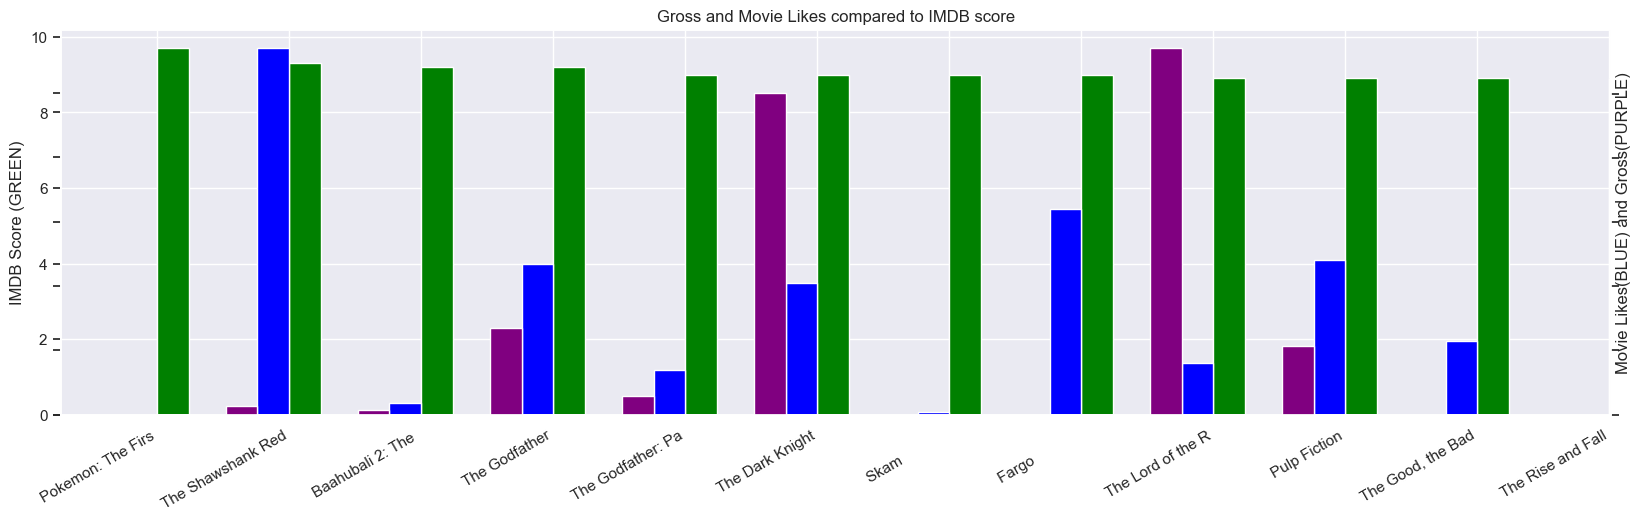

In [16]:
d = df['idmb_score'].apply(float).sort_values(ascending=False)[:12]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
f = df[df.index.isin(d.index)].worldwide_gross.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3= ax2.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
f.plot(kind='bar', color='purple', ax=ax3, width=width, position=2)
ax.set_ylabel('IMDB Score (GREEN)')
ax2.set_ylabel('Movie Likes(BLUE) and Gross(PURPLE)')
ax3.set_yticklabels('')
ax2.set_yticklabels('')
ax.set_xlabel('')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax3.grid(False)
ax2.grid(False)
ax.set_title('Gross and Movie Likes compared to IMDB score')

C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\3348003626.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 10, as_cmap=True),


,nb_awards,domestic_gross,worldwide_gross,total_cast_fb_likes,director_fb_likes,production_budget,num_critic_for_reviews,idmb_score,actor_1_fb_likes,actor_2_fb_likes,actor_3_fb_likes
nb_awards,1.000000,0.264630,0.237191,0.112800,0.240735,0.071708,0.261281,0.383234,0.033452,0.143931,0.131478
domestic_gross,0.264630,1.000000,0.938639,0.302807,0.180407,0.685482,0.505301,0.220947,0.095456,0.351705,0.396350
worldwide_gross,0.237191,0.938639,1.000000,0.301653,0.167893,0.744375,0.527581,0.205946,0.082721,0.364574,0.421002
total_cast_fb_likes,0.112800,0.302807,0.301653,1.000000,0.282200,0.341951,0.360693,0.189968,0.877275,0.636189,0.639322
director_fb_likes,0.240735,0.180407,0.167893,0.282200,1.000000,0.141323,0.236503,0.232527,0.071605,0.220170,0.263124
production_budget,0.071708,0.685482,0.744375,0.341951,0.141323,1.000000,0.514037,0.066819,0.118475,0.407874,0.458044
num_critic_for_reviews,0.261281,0.505301,0.527581,0.360693,0.236503,0.514037,1.000000,0.316915,0.127241,0.458027,0.481783
idmb_score,0.383234,0.220947,0.205946,0.189968,0.232527,0.066819,0.316915,1.000000,0.082113,0.211753,0.213965
actor_1_fb_likes,0.033452,0.095456,0.082721,0.877275,0.071605,0.118475,0.127241,0.082113,1.000000,0.290705,0.251115
actor_2_fb_likes,0.143931,0.351705,0.364574,0.636189,0.220170,0.407874,0.458027,0.211753,0.290705,1.000000,0.823880


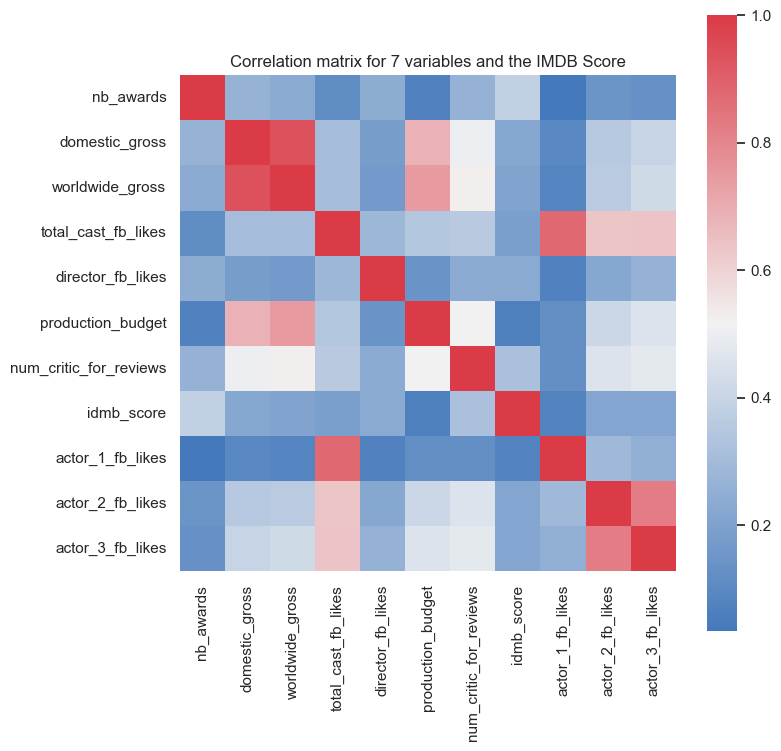

In [17]:
# Correlation Matrix

corr = df[['nb_awards', 'domestic_gross','worldwide_gross', 
    'total_cast_fb_likes','director_fb_likes', 'production_budget',
    'num_critic_for_reviews', 'idmb_score', 'actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes']].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 10, as_cmap=True),
            square=True)
plt.title('Correlation matrix for 7 variables and the IMDB Score')
corr

### Genres

In [18]:
with open(r'C:\Users\duygu\Downloads\final_project\data\raw\genre.json') as f:
    genres = json.load(f)

In [19]:
genres

{'Action': '0',
 'Adventure': '17',
 'Animation': '14',
 'Biography': '20',
 'Comedy': '21',
 'Crime': '10',
 'Documentary': '3',
 'Drama': '18',
 'Family': '19',
 'Fantasy': '6',
 'History': '8',
 'Horror': '4',
 'Music': '12',
 'Musical': '2',
 'Mystery': '16',
 'Romance': '9',
 'Sci-Fi': '13',
 'Short': '5',
 'Sport': '11',
 'Thriller': '7',
 'War': '15',
 'Western': '1'}

In [20]:
import numpy as np
import pandas as pd

imdb_score_per_genre = {}
gross_per_genre = {}
genre_columns = [col for col in df.columns if 'genre_' in col]
df_genres = df[genre_columns]

for genre, value in genres.items():
    mask = df_genres.apply(lambda row: value in row.values, axis=1)
    df_specific_genre = df[mask][['genres', 'idmb_score', 'worldwide_gross']]  # Adjust column names
    
    if not df_specific_genre.empty:
        imdb_score_per_genre[genre] = df_specific_genre['idmb_score'].mean()  # Adjust column name
        gross_per_genre[genre] = df_specific_genre['worldwide_gross'].mean()

# Remove genres with missing gross values
gross_per_genre = {k: v for k, v in gross_per_genre.items() if pd.notnull(v)}

C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\632093281.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = df_genres.apply(lambda row: value in row.values, axis=1)
C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\632093281.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = df_genres.apply(lambda row: value in row.values, axis=1)
C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\632093281.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = df_genres.apply(lambda row: value in row.values, axis=1)
C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\632093281.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = df_genres.apply(lambd

In [21]:
top_k = 5
print('The {} best genres (in terms of IMDB score) are : \n{}'.format(top_k, 
       '\n'.join(['%s (%s)' % (elem[0], round(elem[1], 1)) for elem in sorted(imdb_score_per_genre.items(), key=lambda x:x[1], reverse=True)][:top_k])))

print('\nThe {} most prolific genres are  : \n{}'.format(top_k, 
       '\n'.join(['%s (%s)' % (elem[0], millify(elem[1])) for elem in sorted(gross_per_genre.items(), key=lambda x:x[1], reverse=True)][:top_k])))


The 5 best genres (in terms of IMDB score) are : 


The 5 most prolific genres are  : 



# Prediction

### Preprocessing

In [22]:
with open(r'C:\Users\duygu\Downloads\final_project\data\raw\genre.json') as f:
    genres = json.load(f)

In [23]:
## Fill NA for genres
df.genres  = df.genres.fillna('')

In [24]:
from sklearn.impute import SimpleImputer

col_to_impute = ['actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes',
                'domestic_gross', 'duration_sec', 'num_critic_for_reviews', 'num_facebook_like', 'num_user_for_reviews',
                'production_budget', 'total_cast_fb_likes', 'worldwide_gross', 'director_fb_likes']

for col in col_to_impute:
    column = np.array(df[col]).reshape(-1, 1)  # Reshape the input array
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    df[col] = imp.fit_transform(column)

In [25]:
numerical_cols = list(df.dtypes[df.dtypes != 'object'].index)
not_wanted_cols = ['title_year', 'storyline', 'release_date', 'image_urls', 'movie_title', 'keywords', 'movie_imdb_link', 'num_voted_users'] + genre_columns
df.country = df.country.apply(lambda x:x.split('|'))
df.language = df.language.apply(lambda x:x.split('|'))
list_cols = ['country', 'genres', 'language']
cols_to_transform = [cols for cols in df.columns if cols not in numerical_cols + not_wanted_cols + list_cols]
df2 = df[cols_to_transform]

In [26]:
## Dummies for columns with list
df_col_list = pd.DataFrame()
for col in list_cols:
    df_col_list = pd.concat([df_col_list, pd.get_dummies(df[col].apply(pd.Series).stack()).sum(level=0)], axis=1)

C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\4242683464.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_col_list = pd.concat([df_col_list, pd.get_dummies(df[col].apply(pd.Series).stack()).sum(level=0)], axis=1)
C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\4242683464.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_col_list = pd.concat([df_col_list, pd.get_dummies(df[col].apply(pd.Series).stack()).sum(level=0)], axis=1)
C:\Users\duygu\AppData\Local\Temp\ipykernel_10968\4242683464.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(leve

In [27]:
## Dummies for columns with string
df_col_string = pd.get_dummies(df2, columns=cols_to_transform)

In [28]:
X_raw = pd.concat([df[numerical_cols], df_col_string, df_col_list], axis=1)
print('Columns dtypes :', Counter(X_raw.dtypes))

Columns dtypes : Counter({dtype('uint8'): 12946, dtype('float64'): 13, dtype('int64'): 1})


In [29]:
y = list(X_raw.idmb_score)
X = X_raw.drop('idmb_score', axis=1)

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
print('Train', X_train.shape, 'Test', X_test.shape)

Train (4080, 12959) Test (1020, 12959)


# Choosing ML algorithm

In [31]:
from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Use 'median' or 'most_frequent' if appropriate

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train)

# Apply the same imputer to the test data
X_test_imputed = imputer.transform(X_test)

In [32]:
# Remove rows with any NaN values from both X_train and X_test
X_train_cleaned = X_train.dropna()
X_test_cleaned = X_test.dropna()

In [33]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=1000)
gbr.fit(X_train_imputed, Y_train)
print("Training Score GradientBoosting: ", str(gbr.score(X_train_imputed, Y_train)))
print("Test Score GradientBoosting: ", str(gbr.score(X_test_imputed, Y_test)))

Training Score GradientBoosting:  0.7823104239284382
Test Score GradientBoosting:  0.4400032046655886


In [34]:
abr = ensemble.AdaBoostRegressor(n_estimators=10, learning_rate=0.4, loss='linear')
abr.fit(X_train_imputed,Y_train)
print ("Training Score AdaBoostRegressor: ", str(abr.score(X_train_imputed,Y_train)))
print ("Test Score AdaBoostRegressor: " , str(abr.score(X_test_imputed,Y_test)))

Training Score AdaBoostRegressor:  0.35461013902599103
Test Score AdaBoostRegressor:  0.34382773724385196


In [35]:
rf=ensemble.RandomForestRegressor(n_estimators=500,oob_score=True, ) 
rf.fit(X_train_imputed,Y_train)
print ("Training Score RandomForest: ", str(rf.score(X_train_imputed,Y_train)))
print ("Cross Validation (10 fold) Score: " , np.mean(cross_val_score(rf, X_train_imputed, Y_train, cv=10)))

Training Score RandomForest:  0.9282305450949454
Cross Validation (10 fold) Score:  0.4806215577596068


### Tuning

#### Cross Validation to choose n_estimators

In [36]:
rfs = {}
for k in [10, 20, 50, 70, 100, 120, 150, 200]:
    rf=ensemble.RandomForestRegressor(n_estimators=k, oob_score=True) 
    rf.fit(X_train_imputed,Y_train)
    rfs[k] = np.mean(cross_val_score(rf, X_train_imputed, Y_train, cv=5))

C:\Users\duygu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\duygu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\duygu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\duygu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\duygu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probab

Text(0, 0.5, 'Cross Validation score')

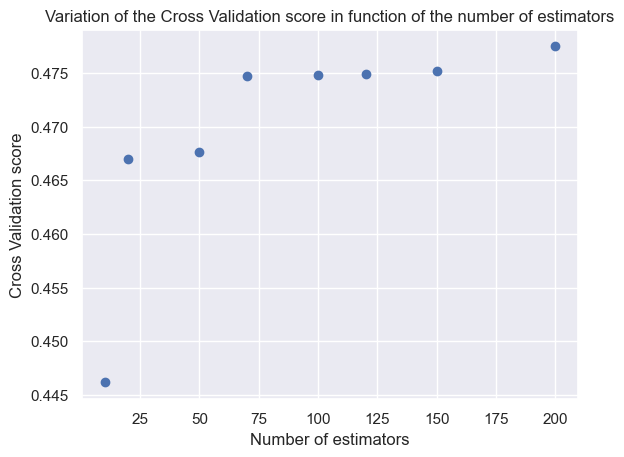

In [37]:
x_plot = list(rfs.keys())
y_plot = list(rfs.values())

f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the number of estimators')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Cross Validation score')

### Min leaf

In [38]:
rfs2 = {}
for k in tqdm(list(range(1, 11, 2))+list(range(11,25,4))):
    rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, min_samples_leaf=k) 
    rf.fit(X,y)
    rfs2[k] = rf.oob_score_

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [24:28<00:00, 163.15s/it]


Text(0, 0.5, 'OOB score')

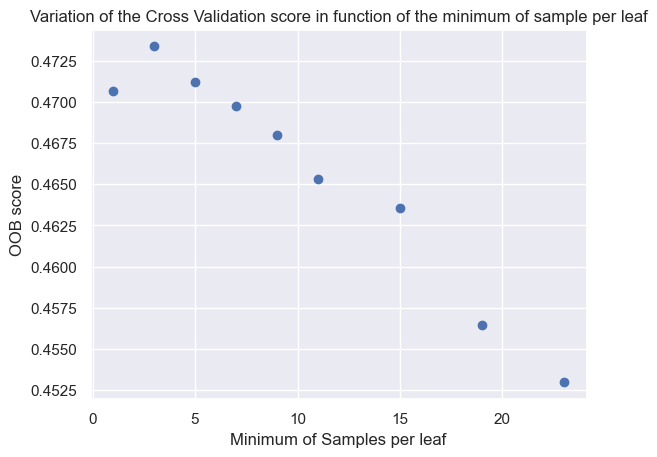

In [39]:
x_plot = list(rfs2.keys())
y_plot = list(rfs2.values())

f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the minimum of sample per leaf')
ax.set_xlabel('Minimum of Samples per leaf')
ax.set_ylabel('OOB score')

## max_features

In [40]:
rfs2 = {}
for k in ["log2", "auto", "sqrt", 0.2, 0.1, 0.3] :
    rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, min_samples_leaf= 1, max_features = k) 
    rf.fit(X,y)
    rfs2[k] = rf.oob_score_

C:\Users\duygu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


['log2', 'auto', 'sqrt', 0.2, 0.1, 0.3]


Text(0, 0.5, 'Cross Validation score')

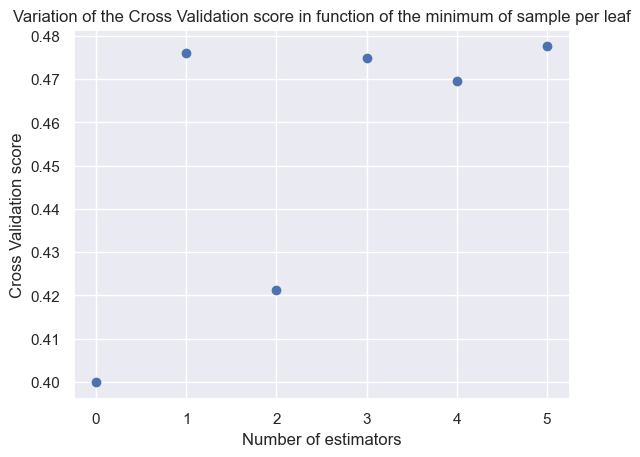

In [41]:
x_plot = range(len(rfs2))# list(rfs2.keys())
y_plot = list(rfs2.values())
print(list(rfs2.keys()))
f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the minimum of sample per leaf')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Cross Validation score')

## Learning

In [42]:
rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, max_features=0.2, min_samples_leaf=5) 
rf.fit(X,y)
print ("Training Score RandomForest: ", str(rf.score(X,y)))
print ("OOB Score RandomForest: " , str(rf.oob_score_))

Training Score RandomForest:  0.6765861479299211
OOB Score RandomForest:  0.4697352612136422


## Most important features

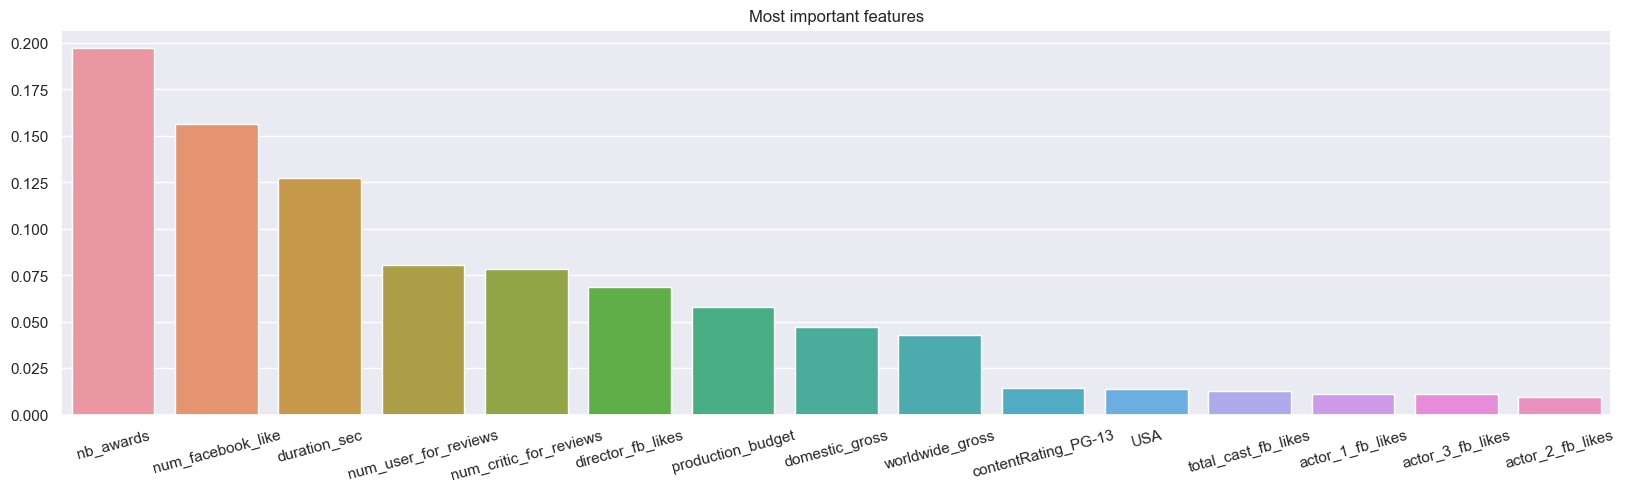

In [43]:
top_k = 15
plt.figure(figsize=(20,5))
names = X_train.columns[np.argsort(rf.feature_importances_)[::-1][:top_k]]
values = np.sort(rf.feature_importances_)[::-1][:top_k]
plot = sns.barplot(x = names, y = values, order=names)
_ = plot.set_xticklabels(names, rotation=15)
_ = plot.set_title('Most important features')

## RESULT

Main question : How can we tell the greatness of a movie before it is released in cinema?

Answer : Most important features that are listed effects the greatness of a movie before it is released in cinema.